# MODEL PARP

# Bionformatika RB- Kelompok 4

# Data Preparation

In [1]:
# Instalasi machine Learning Package
import sys
import time
import contextlib
with open('install_ML.log', 'a') as inpt:
    with contextlib.redirect_stdout(inpt):

        # -- Start installation --
        start = time.time()
        !pip install cairosvg
        !pip install padelpy
        !pip install gdown
        !pip install luwiji
        !pip install jcopml
        !pip install chembl_webresource_client

        from luwiji.knn import illustration, demo

        import matplotlib.pyplot as plt
        import seaborn as sns
        import os
        import copy
        from padelpy import padeldescriptor
        import pandas as pd
        import numpy as np

        from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
        from chembl_webresource_client.new_client import new_client
        end = time.time()
        # -- End installation --
print(f'+ Time elapsed: ' + time.strftime('%Mm %Ss', time.gmtime(end - start)))

+ Time elapsed: 00m 49s


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

### data 1 (lipsinky)

In [114]:
df_lipinsky = pd.read_csv('/content/label2classPARP.csv')
df_lipinsky

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL469961,active,CC1(C)CC(c2nc3c(C(N)=O)cccc3[nH]2)C(C)(C)N1O,302.378,2.39750,3.0,4.0,6.142065
1,CHEMBL470166,active,CC1(C)C(Br)=C(c2nc3c(C(N)=O)cccc3[nH]2)C(C)(C)N1O,379.258,3.02980,3.0,4.0,6.696804
2,CHEMBL513759,active,CC1(C)C(c2cccc(C(F)(F)F)c2)=C(c2nc3c(C(N)=O)cc...,444.457,4.85340,3.0,4.0,6.826814
3,CHEMBL459362,active,CC1(C)C=C(c2ccc(-c3nc4c(C(N)=O)cccc4[nH]3)cc2)...,376.460,3.97420,3.0,4.0,7.107905
4,CHEMBL518018,active,CC1(C)C=C(c2nc3c(C(N)=O)cccc3[nH]2)CC(C)(C)N1O,314.389,2.69730,3.0,4.0,7.585027
...,...,...,...,...,...,...,...,...
2632,CHEMBL3698974,active,NC(=O)c1cccc2c1C(=O)N(CCCN1CCN(c3cccc(Cl)c3)CC...,412.921,2.60700,1.0,4.0,6.397940
2633,CHEMBL3605984,active,Cc1ccc(CN2CCC(CN3Cc4cccc(C(N)=O)c4C3=O)CC2)cc1,377.488,2.96192,1.0,3.0,7.096910
2634,CHEMBL3699003,active,NC(=O)c1cccc2c1C(=O)N(CC1CCN(Cc3ccc(F)cc3)CC1)C2,381.451,2.79260,1.0,3.0,6.795880
2635,CHEMBL3699004,active,NC(=O)c1cc(F)cc2c1C(=O)N(C1CCN(C3CCC(=O)CC3)CC...,373.428,1.85650,1.0,4.0,7.096910


### Transformasi class ke numerik ordinal

In [140]:
mapping = {'active': 0, 'inactive': 1}
df_lipinsky['class_numeric'] = df_lipinsky['class'].map(mapping)

df_lipinsky

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50,class_numeric
0,CHEMBL469961,active,CC1(C)CC(c2nc3c(C(N)=O)cccc3[nH]2)C(C)(C)N1O,302.378,2.39750,3.0,4.0,6.142065,0
1,CHEMBL470166,active,CC1(C)C(Br)=C(c2nc3c(C(N)=O)cccc3[nH]2)C(C)(C)N1O,379.258,3.02980,3.0,4.0,6.696804,0
2,CHEMBL513759,active,CC1(C)C(c2cccc(C(F)(F)F)c2)=C(c2nc3c(C(N)=O)cc...,444.457,4.85340,3.0,4.0,6.826814,0
3,CHEMBL459362,active,CC1(C)C=C(c2ccc(-c3nc4c(C(N)=O)cccc4[nH]3)cc2)...,376.460,3.97420,3.0,4.0,7.107905,0
4,CHEMBL518018,active,CC1(C)C=C(c2nc3c(C(N)=O)cccc3[nH]2)CC(C)(C)N1O,314.389,2.69730,3.0,4.0,7.585027,0
...,...,...,...,...,...,...,...,...,...
2632,CHEMBL3698974,active,NC(=O)c1cccc2c1C(=O)N(CCCN1CCN(c3cccc(Cl)c3)CC...,412.921,2.60700,1.0,4.0,6.397940,0
2633,CHEMBL3605984,active,Cc1ccc(CN2CCC(CN3Cc4cccc(C(N)=O)c4C3=O)CC2)cc1,377.488,2.96192,1.0,3.0,7.096910,0
2634,CHEMBL3699003,active,NC(=O)c1cccc2c1C(=O)N(CC1CCN(Cc3ccc(F)cc3)CC1)C2,381.451,2.79260,1.0,3.0,6.795880,0
2635,CHEMBL3699004,active,NC(=O)c1cc(F)cc2c1C(=O)N(C1CCN(C3CCC(=O)CC3)CC...,373.428,1.85650,1.0,4.0,7.096910,0


### data 2 (finger print)

In [188]:
df_fp = pd.read_csv('/content/datamodelPARP.csv')
df_fp = df_fp.drop(columns=['pIC50','MW','LogP','NumHDonors','NumHAcceptors'])
df_fp

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,1,1,1,0,0,1,1,1,0,0,...,0,0,0,1,0,1,0,1,0,1
1,1,1,1,0,0,1,1,1,0,0,...,0,1,0,1,0,1,0,1,0,1
2,1,1,1,0,0,1,1,1,1,0,...,0,0,0,1,0,1,0,1,0,1
3,1,1,1,0,1,1,1,1,1,0,...,0,0,1,1,0,1,1,1,0,1
4,1,1,1,0,0,1,1,1,0,0,...,0,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,1,1,1,0,0,1,1,1,1,0,...,0,1,1,0,1,0,1,0,1,0
2633,1,0,1,0,0,1,1,1,1,0,...,0,1,1,0,1,0,1,0,1,0
2634,1,0,1,0,1,1,1,1,1,0,...,0,1,1,0,1,0,1,0,1,0
2635,1,0,1,0,1,1,1,1,1,0,...,0,1,1,0,1,0,1,0,1,0


### data 3 (combine)

In [189]:
df_combined = pd.concat([df_lipinsky,df_fp], axis=1)
df_combined.head()

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50,class_numeric,0,...,126,127,128,129,130,131,132,133,134,135
0,CHEMBL469961,active,CC1(C)CC(c2nc3c(C(N)=O)cccc3[nH]2)C(C)(C)N1O,302.378,2.3975,3.0,4.0,6.142065,0,1,...,0,0,0,1,0,1,0,1,0,1
1,CHEMBL470166,active,CC1(C)C(Br)=C(c2nc3c(C(N)=O)cccc3[nH]2)C(C)(C)N1O,379.258,3.0298,3.0,4.0,6.696804,0,1,...,0,1,0,1,0,1,0,1,0,1
2,CHEMBL513759,active,CC1(C)C(c2cccc(C(F)(F)F)c2)=C(c2nc3c(C(N)=O)cc...,444.457,4.8534,3.0,4.0,6.826814,0,1,...,0,0,0,1,0,1,0,1,0,1
3,CHEMBL459362,active,CC1(C)C=C(c2ccc(-c3nc4c(C(N)=O)cccc4[nH]3)cc2)...,376.460,3.9742,3.0,4.0,7.107905,0,1,...,0,0,1,1,0,1,1,1,0,1
4,CHEMBL518018,active,CC1(C)C=C(c2nc3c(C(N)=O)cccc3[nH]2)CC(C)(C)N1O,314.389,2.6973,3.0,4.0,7.585027,0,1,...,0,0,0,1,0,1,0,1,0,1


In [211]:
X = df_combined.drop(columns=['molecule_chembl_id', 'canonical_smiles', 'class', 'class_numeric', 'MW','LogP', 'NumHDonors', 'NumHAcceptors', 'pIC50'])
X = X.astype(float)
X


,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
4,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2633,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2634,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2635,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [212]:
y= df_combined['class_numeric']
y

,class_numeric
0,0
1,0
2,0
3,0
4,0
...,...
2632,0
2633,0
2634,0
2635,0


In [213]:
y.value_counts()

,count
class_numeric,
0,2276
1,361


### Fix Imbalanced Data with SMOTE technique

In [214]:
from imblearn.over_sampling import SMOTE
ros = SMOTE(random_state=42)
X_balance, y_balance = ros.fit_resample(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [215]:
X_balance

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,1.0,1.0,1.000000,0.0,0.000000,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,1.0,1.0,1.000000,0.0,0.000000,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,1.0,1.0,1.000000,0.0,0.000000,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,1.0,1.0,1.000000,0.0,1.000000,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
4,1.0,1.0,1.000000,0.0,0.000000,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4547,1.0,1.0,1.000000,0.0,0.000000,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4548,1.0,1.0,1.000000,0.0,0.709954,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4549,1.0,1.0,0.871414,0.0,0.000000,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4550,1.0,1.0,1.000000,1.0,1.000000,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [216]:
y_balance

,class_numeric
0,0
1,0
2,0
3,0
4,0
...,...
4547,1
4548,1
4549,1
4550,1


In [217]:
y_balance.value_counts()

,count
class_numeric,
0,2276
1,2276


### Split Data

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X_balance, y_balance, test_size=0.2, random_state=42)

In [219]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3641, 136), (911, 136), (3641,), (911,))

# Model

## Support Vector Machine (klasifikasi bioaktivitas PARP)

### Komparasi Kernel SVM

In [220]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
accuracy = svm_model.score(X_test, y_test)
print("Akurasi SVM Kernel linear:", accuracy)


Akurasi SVM Kernel linear: 0.8880351262349067


In [221]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)
accuracy = svm_model.score(X_test, y_test)
print("Akurasi SVM kernel RBF:", accuracy)


Akurasi SVM kernel RBF: 0.9538968166849616


In [222]:
from sklearn.svm import SVC
svm_model = SVC(kernel='poly')
svm_model.fit(X_train, y_train)
accuracy = svm_model.score(X_test, y_test)
print("Akurasi SVM kernel polynomial:", accuracy)


Akurasi SVM kernel polynomial: 0.9517014270032931


In [223]:
from sklearn.svm import SVC
svm_model = SVC(kernel='sigmoid')
svm_model.fit(X_train, y_train)
accuracy = svm_model.score(X_test, y_test)
print("Akurasi SVM kernel sigmoid:", accuracy)


Akurasi SVM kernel sigmoid: 0.4994511525795829


### Pipeline

In [224]:

numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", MinMaxScaler())
])
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("ordinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

numeric = []
categoric = [col for col in X_train.columns if col not in numeric]

preprocessor = ColumnTransformer([
    ("numeric", numerical_pipeline, numeric),
    ("categoric", categorical_pipeline,categoric)
])


In [225]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("classifier", SVC())
])

In [226]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  []),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['0', '1', '2', '3', '4', '5',
                                                   '6', '7', '8', '9', '10',
                                                   '11', '12', '13', '14', '15',
                                                   '16', '17', '18', '19', '20',
                                                   '21', '22', '23', '24', '25',
                                                   '26', '27', '28', '29', ...])])),
                ('classifier', SVC())])

### Hyperparameter Tuning

In [227]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Buat pipeline SVC
pipeline = Pipeline([('classifier', svm.SVC())])

# Definisikan parameter tuning untuk SVC
param_grid = {
    'classifier__C': [1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__degree': [2, 3, 4]
}

# Buat model GridSearchCV
model = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, return_train_score=True)

# Latih model
model.fit(X_train, y_train)

# Cetak hasil
print("Parameter terbaik:", model.best_params_)
print("Akurasi terbaik:", model.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Parameter terbaik: {'classifier__C': 10, 'classifier__degree': 2, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Akurasi terbaik: 0.9530344141455253


### predict

In [ ]:
y_pred = pipeline.predict(X_test)

In [229]:
y_pred_best = model.predict(X_test)

### Prediksi Klasifikasi

In [231]:
X_pred = X.iloc[17:30]

In [232]:
X_pred["class_numeric"] = model.predict(X_pred)
X_pred

<ipython-input-232-4bc60750d888>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred["class_numeric"] = model.predict(X_pred)


,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,class_numeric
17,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0
18,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0
19,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0
20,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
21,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0
22,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1
23,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1
24,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0
26,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


### Classification Report (Precision, recall, f1-score)

In [233]:
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best))


Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       459
           1       0.96      0.98      0.97       452

    accuracy                           0.97       911
   macro avg       0.97      0.97      0.97       911
weighted avg       0.97      0.97      0.97       911



In [234]:
print("\nClassification Report (Best Model SVM):")
print(classification_report(y_test, y_pred_best))



Classification Report (Best Model SVM):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       459
           1       0.96      0.98      0.97       452

    accuracy                           0.97       911
   macro avg       0.97      0.97      0.97       911
weighted avg       0.97      0.97      0.97       911



### Confusion matrix

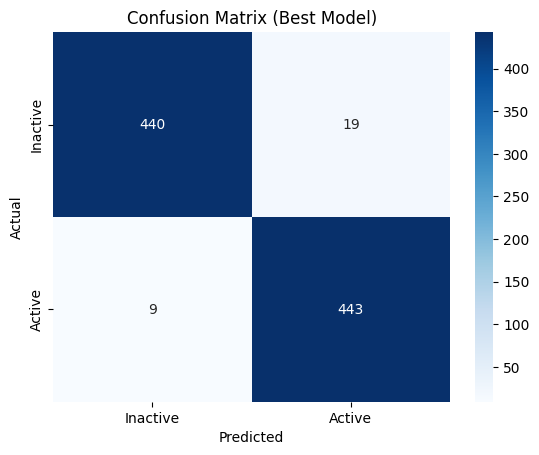

In [235]:
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Model)')
plt.show()


### Distribusi Fingerprint descriptor

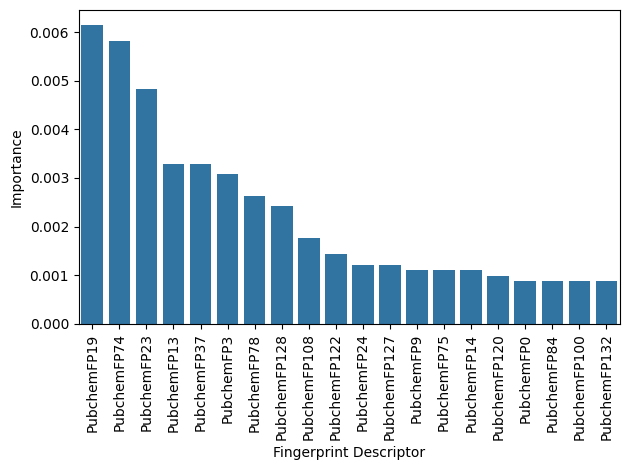

In [236]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(model, X_test, y_test, n_repeats=10)
imp_values = importance.importances_mean
fp = sorted(range(len(imp_values)), key=lambda i: imp_values[i], reverse=True)[:20]

fake = pd.DataFrame({'ind': ['PubchemFP'+str(i) for i in fp],
                     'importance': [imp_values[i] for i in fp]})

ax = sns.barplot(x='ind', y='importance', data=fake)
ax.set(xlabel='Fingerprint Descriptor', ylabel='Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Save Model

In [237]:
import pickle, os

os.makedirs("model_output", exist_ok = True)
pickle.dump(model, open("model_output/svm.pkl", "wb"))

In [238]:
import pickle, os

os.makedirs("model_output", exist_ok = True)
pickle.dump(model, open("model_output/svm.hdf5", "wb"))

In [239]:
import pickle, os

os.makedirs("model_output", exist_ok = True)
pickle.dump(model, open("model_output/svm.h5", "wb"))

## Support Vector Machine (Estimasi nilai pIC50 Bioaktivitas PARP)

### Library

In [169]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load data

In [170]:
#Load data
df = pd.read_csv('/content/label2classPARP.csv')
df

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL469961,active,CC1(C)CC(c2nc3c(C(N)=O)cccc3[nH]2)C(C)(C)N1O,302.378,2.39750,3.0,4.0,6.142065
1,CHEMBL470166,active,CC1(C)C(Br)=C(c2nc3c(C(N)=O)cccc3[nH]2)C(C)(C)N1O,379.258,3.02980,3.0,4.0,6.696804
2,CHEMBL513759,active,CC1(C)C(c2cccc(C(F)(F)F)c2)=C(c2nc3c(C(N)=O)cc...,444.457,4.85340,3.0,4.0,6.826814
3,CHEMBL459362,active,CC1(C)C=C(c2ccc(-c3nc4c(C(N)=O)cccc4[nH]3)cc2)...,376.460,3.97420,3.0,4.0,7.107905
4,CHEMBL518018,active,CC1(C)C=C(c2nc3c(C(N)=O)cccc3[nH]2)CC(C)(C)N1O,314.389,2.69730,3.0,4.0,7.585027
...,...,...,...,...,...,...,...,...
2632,CHEMBL3698974,active,NC(=O)c1cccc2c1C(=O)N(CCCN1CCN(c3cccc(Cl)c3)CC...,412.921,2.60700,1.0,4.0,6.397940
2633,CHEMBL3605984,active,Cc1ccc(CN2CCC(CN3Cc4cccc(C(N)=O)c4C3=O)CC2)cc1,377.488,2.96192,1.0,3.0,7.096910
2634,CHEMBL3699003,active,NC(=O)c1cccc2c1C(=O)N(CC1CCN(Cc3ccc(F)cc3)CC1)C2,381.451,2.79260,1.0,3.0,6.795880
2635,CHEMBL3699004,active,NC(=O)c1cc(F)cc2c1C(=O)N(C1CCN(C3CCC(=O)CC3)CC...,373.428,1.85650,1.0,4.0,7.096910


In [171]:
fitur = ['class','MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
target = 'pIC50'

### Encoding & Standarisasi

In [172]:
#Encoding fitur'class'
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])
X = df[fitur]
y = df[target]

# Standarisasi data numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Split Data

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


### Model

In [175]:
model = SVR(kernel='rbf')
model.fit(X_train, y_train)

#prediksi
y_pred = model.predict(X_test)
y_pred


array([4.68428494, 7.3781124 , 7.32017581, 7.30925212, 7.80465818,
       7.35623686, 7.26940245, 7.56711375, 7.7149636 , 4.68418361,
       6.87268648, 6.32561239, 7.50543014, 7.20459505, 8.15641302,
       7.27464804, 7.89731721, 6.8128195 , 6.42009299, 7.31110088,
       7.77596076, 8.77533651, 7.26100114, 7.72896069, 6.86873909,
       7.86550741, 7.1471077 , 7.80048446, 7.30734568, 7.69471856,
       7.75118531, 7.84703771, 7.59245914, 7.28293306, 7.2824126 ,
       7.17863656, 7.27058329, 7.10256832, 6.72743773, 6.95635752,
       7.56341768, 7.0448092 , 7.2549737 , 7.4602075 , 7.94841237,
       7.16104955, 4.59377252, 7.37388276, 6.69230023, 7.48094128,
       7.38945585, 4.20333387, 7.75813932, 7.21895772, 8.01657155,
       4.35152902, 7.20246803, 7.01236024, 7.74373895, 6.4917925 ,
       4.71541173, 7.85137079, 7.43726294, 7.56358131, 8.03063831,
       7.1597907 , 7.2219462 , 8.23438359, 7.73393819, 7.23678142,
       7.69251237, 7.38713531, 7.97276184, 7.34862261, 7.16086

### Evaluasi Model

In [179]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MSE: 0.4784760635558444
MAE: 0.5337557387841745
RMSE: 0.6917196423088218


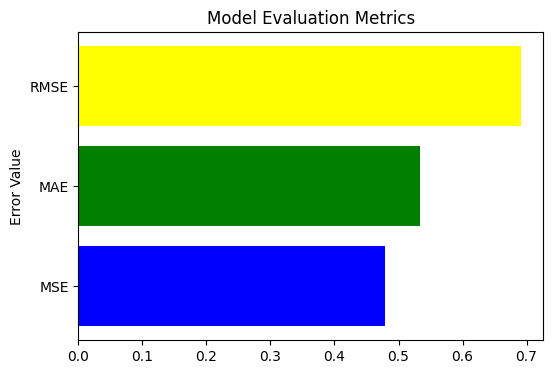

In [181]:
#plot
errors = [mse, mae, rmse]
error_names = ['MSE', 'MAE', 'RMSE']

plt.figure(figsize=(6, 4))
plt.barh(error_names, errors, color=['blue', 'green','yellow'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Error Value')
plt.show()


In [185]:
import pickle, os

os.makedirs("model_output", exist_ok = True)
pickle.dump(model, open("prediksipIC50SVM.h5", "wb"))

In [186]:
import pickle, os

os.makedirs("model_output", exist_ok = True)
pickle.dump(model, open("prediksipIC50SVM.hdf5", "wb"))

In [187]:
import pickle, os

os.makedirs("model_output", exist_ok = True)
pickle.dump(model, open("prediksipIC50SVM.tf", "wb"))